## AlexNet model

This part of the lab is adapted from [kuangliu's PyTorch CIFAR repository on GitHub](https://github.com/kuangliu/pytorch-cifar/blob/master/models/googlenet.py).

From class, we now know that the AlexNet model (without splitting across GPUs) looks like this:

<img src="figures/alexnet.png" title="AlexNet (Alex et al.)" style="width: 900px;" />

## AlexNet Coding in PyTorch

First, we import some necessary libraries:

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F

Next, we set up Dataset objects and DataLoader objects to load images, transform them to 3x224x224, and batch them for training/testing:

In [4]:
# Set up preprocessing of CIFAR-10 images to 3x224x224 with normalization
# using the magic ImageNet means and standard deviations. You can try
# RandomCrop, RandomHorizontalFlip, etc. during training to obtain
# slightly better generalization.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets

train_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10', train=True, download=True, transform=preprocess)

# Split the training set into training and validation sets randomly.
# CIFAR-10 train contains 50,000 examples, so let's split 80%/20%.
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

# Download the test set. If you use data augmentation transforms for the training set,
# you'll want to use a different transformer here.
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10', train=False, download=True, transform=preprocess)

# Dataset objects are mainly designed for datasets that can't fit entirely into memory.
# Dataset objects don't load examples into memory until their __getitem__() method is
# called. For supervised learning datasets, __getitem__() normally returns a 2-tuple
# on each call. To make a Dataset object like this useful, we use a DataLoader object
# to optionally shuffle then batch the examples in each dataset. During training.
# To keep our memory utilization small, we'll use 4 images per batch, but we could use
# a much larger batch size on a dedicated GPU. To obtain optimal usage of the GPU, we
# would like to load the examples for the next batch while the current batch is being
# used for training. DataLoader handles this by spawining "worker" threads that proactively
# fetch the next batch in the background, enabling parallel training on the GPU and data
# loading/transforming/augmenting on the CPU. Here we use num_workers=2 (the default)
# so that two batches are always ready or being prepared.

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,   batch_size=4, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,  batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Next, we set up to execute on a particular GPU or the CPU only:

In [3]:
# Device 'cuda' or 'cuda:0' means GPU slot 0.
# If you have more than one GPU, you can select other GPUs using 'cuda:1', 'cuda:2', etc.
# In terminal (Linux), you can check memory using in each GPU by using command
# $ nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cpu


## "AlexNet" with the Sequential API

PyTorch deep learning models come in (at least) two possible styles:

<img src="figures/NNinPytorch.png" style="width: 500px;" />

1. The PyTorch Sequential API is very expressive when we have a straightforward sequence of operations to perform on the input.
2. The PyTorch neural network Module allows more flexible transformations of inputs, combination of multiple inputs, generation of multiple outputs, and so on.

We will see that AlexNet (at least a simple form of AlexNet) can mostly be expressed as a Sequential process, whereas GoogLeNet, with its
parallel branches within Inception modules, requires the use of the Module API.

### The model

Let's express an AlexNet-like network using `torch.nn.Sequential`:


In [4]:
# Simple module to flatten a batched feature map tensor into a batched vector tensor

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

# AlexNet-like model using the Sequential API

NUM_CLASSES = 10

alexnet_sequential = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, NUM_CLASSES)
)

# Move model to target device

alexnet_sequential = alexnet_sequential.to(device)

At this point, by the way, it would be useful to go back to the [AlexNet paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
and ask what is missing in this version of the model?

### Training function

Next, let's write a function to train our model for some number of epochs. This one is adapted from the PyTorch tutorials.

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in
            
            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backpropagate only if in training phase

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

### Optimizer and loss function

Before we start training, we need to set up an optimizer object and a loss function. Typical choices for the loss function:
* For regression problems, we would normally use `nn.MSELoss()`. The equation is:
$$MSE=\frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2 $$
* For binary classification, we normally use `nn.BCELoss()`:
$$BCE=-\frac{1}{N}\sum_{i=1}^N y_i\cdot \log{\hat{y}_i} + (1-y_i)\cdot \log(1 -{\hat{y}_i})$$
* For multinomial classification, we most often use `nn.CrossEntropyLoss()`:
$$CE=-\sum_{i=1}^C t_i\cdot \log(f(s)_i),$$
where $t_i$ and $s_i$ are the ground truth and the CNN prediction for each class $i$ in $1..C$.
An activation function (Sigmoid / Softmax) is usually applied to the scores before the CE Loss computation, so $f(s)_i$ refers to the nonlinear activation function application.

For specialized needs, you can define your own loss function! We'll see examples of that later in the course.

Typical choices for the optimizer:
* SGD: Scholastic gradient descent, works well for most cases but requires appropriate values for the learning, momentum, and weight decay. Given $\alpha$ is learning rate, and $\beta$ is momentum, the equation is

$$V_t = \beta V_{t-1} + (1-\beta)\nabla_wL(W,X,y)$$
$$W_{t+1} = W_t + \alpha V_t$$

 for more information please see [Stochastic Gradient Descent with momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d)

* Adam: adaptive learning rate optimizer that usually gives superior results to SGD but sometimes doesn't work. Adam's equations are:
$$(m_t)_i=\beta_1(m_{t-1})_i+(1-\beta_1)(\nabla(W_t))_i,$$
$$(v_t)_i=\beta_2(v_{t-1})_i+(1-\beta_2)(\nabla(W_t))_i^2,$$
$$(W_{t+1})i=(W_t)_i-\alpha\frac{\sqrt{1-(\beta_2)_i^t}}{1-(\beta_i)_i^t}\frac{(m_t)_i}{\sqrt{(v_t)_i}+\epsilon}$$
* See the many other choices selected from recent deep learning papers in the [PyTorch optim documentation](https://pytorch.org/docs/stable/optim.html).


In [6]:
# CrossEntropyLoss for multinomial classification (because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet_sequential.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

## Training the model

Use train_model function for training.

In [7]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

best_model, val_acc_history, loss_acc_history = train_model(alexnet_sequential, dataloaders, criterion, optimizer, 10, 'alex_sequential_lr_0.001_bestsofar')

Epoch 0/9
----------
train Loss: 1.7464 Acc: 0.3524
Epoch time taken:  76.76025462150574
val Loss: 1.3577 Acc: 0.5049
Epoch time taken:  83.65061354637146

Epoch 1/9
----------
train Loss: 1.2213 Acc: 0.5644
Epoch time taken:  76.73192644119263
val Loss: 1.0506 Acc: 0.6226
Epoch time taken:  83.35552620887756

Epoch 2/9
----------
train Loss: 0.9679 Acc: 0.6609
Epoch time taken:  76.92400431632996
val Loss: 0.9124 Acc: 0.6828
Epoch time taken:  83.58274269104004

Epoch 3/9
----------
train Loss: 0.8160 Acc: 0.7177
Epoch time taken:  76.84008717536926
val Loss: 0.7564 Acc: 0.7386
Epoch time taken:  83.81382274627686

Epoch 4/9
----------
train Loss: 0.7024 Acc: 0.7541
Epoch time taken:  77.08730220794678
val Loss: 0.8350 Acc: 0.7128
Epoch time taken:  84.01303172111511

Epoch 5/9
----------
train Loss: 0.6233 Acc: 0.7858
Epoch time taken:  77.0996687412262
val Loss: 0.6750 Acc: 0.7672
Epoch time taken:  84.05988454818726

Epoch 6/9
----------
train Loss: 0.5447 Acc: 0.8088
Epoch time ta

## AlexNet using the Module API

The Sequential API makes it easy to create a sequential model, but not all models are sequential. For example, we need more flexibility
to create a complex model such as GoogLeNet.

Working with the `Module` API requires us to use object-oriented inheritance in Python. This means you'll have to brush up on your OO concepts or learn the basics if OOP is new to you.

We create a new class that inherits from `Module`, then in most cases, we just need to override two methods: `__init__()` and `forward()`.

`__init__()` is called the "constructor" of a class and is the method called on any Python object just after it is created, similar to constructors in Java or C++.

However, constructors and instance methods work a little differently in Python than they do in Java or C++. The constructor is just an ordinary instance method that is only special in that it
is called implicitly when the object is created. Instance methods in Python (methods called on an object) are distinguished from class methods (methods called on the class, not requiring any
instance) by the presence or absence of the `self` keyword in the parameter list. In the body of an instance method, `self` is a reference to the instance the method was called on, same as
`this` in Java or C++ or `self` in Ruby.

Anther difference between Python and other languages is that object initialization in an inheritance hierarchy is more flexible.
A constructor should normally call `super(ClassName, self).__init__()` (Python 2, also works in Python 3) or `super().__init__()` (Python 3 only) at the beginning of its
own `__init__()` method to initialze any fields used by methods in the superclass, but it need not do so.

In the case of a PyTorch `Module` subclass, we should call `super()` before doing other things.

The `forward()` method is also an instance method that is implicitly called when we invoke a `Module` instance as a function. So the code

    module = MyModule()
    
creates an instance of `MyModule` and then calls its `__init__()` method, whereas

    outputs = module(inputs)

invokes the `forward()` method defined in `MyModule`.

### The model

Here's an implementation of an AlexNet-like network.

Note that `Sequential` is itself a subclass of `Module`. This means we can use `Sequential` for a sequential flow in a larger network.

Also note that the adaptive average pool layer between the feature module and the classifier is a trick used to ensure a fixed set of 6x6 feature maps come out
of the feature extractor regardless of the input image size. It is not strictly required here (and not used in the original paper) but would allow us to use other input sizes besides 224x224 if we like.


In [34]:
class AlexNetModule(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Training the model

In [36]:
alexnet = AlexNetModule(10).to(device)
# Make optimizer and Loss function
criterion_2 = nn.CrossEntropyLoss()
params_to_update_2 = alexnet.parameters()
optimizer_2 = optim.SGD(params_to_update_2, lr=0.001, momentum=0.9)

In [18]:
best_model2, val_acc_history2, loss_acc_history2 = train_model(
    alexnet, dataloaders, criterion_2, optimizer_2, 10, 'alex_module_lr_0.001_bestsofar')

Epoch 0/9
----------
train Loss: 0.8005 Acc: 0.7222
Epoch time taken:  74.37363409996033
val Loss: 0.7667 Acc: 0.7361
Epoch time taken:  81.21031284332275

Epoch 1/9
----------
train Loss: 0.6968 Acc: 0.7586
Epoch time taken:  72.87970519065857
val Loss: 0.7414 Acc: 0.7506
Epoch time taken:  79.862961769104

Epoch 2/9
----------
train Loss: 0.6137 Acc: 0.7868
Epoch time taken:  76.41032123565674
val Loss: 0.7180 Acc: 0.7534
Epoch time taken:  83.27066278457642

Epoch 3/9
----------
train Loss: 0.5458 Acc: 0.8103
Epoch time taken:  72.94309997558594
val Loss: 0.7124 Acc: 0.7640
Epoch time taken:  79.88523292541504

Epoch 4/9
----------
train Loss: 0.4960 Acc: 0.8270
Epoch time taken:  72.0707139968872
val Loss: 0.6915 Acc: 0.7672
Epoch time taken:  79.07196426391602

Epoch 5/9
----------
train Loss: 0.4449 Acc: 0.8461
Epoch time taken:  72.26198840141296
val Loss: 0.6603 Acc: 0.7824
Epoch time taken:  79.15270256996155

Epoch 6/9
----------
train Loss: 0.4093 Acc: 0.8586
Epoch time take

### Plot results

Based on these results, let's plot the validation loss/accuracy curves:

In [19]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

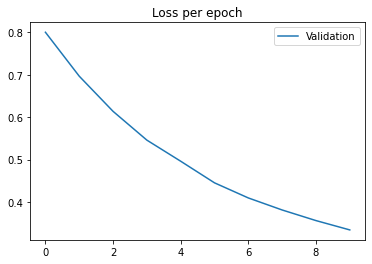

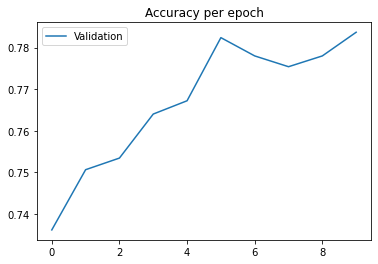

In [20]:
plot_data(val_acc_history2, loss_acc_history2)